In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

original_df = pd.read_csv("EWKino-train.csv")
original_df.head()

,M_1,M_2,mu,tan_beta,M_3,At,Ab,Atau,mA,mqL3,mtR,mbR,DM_relic_density
0,1560.24490,349.94913,186.18735,24.124987,3479.3865,1590.2957,1601.209700,1081.743300,4912.0930,3819.487549,4131.721680,3952.087891,-5.326717
1,-522.80970,1570.04090,1124.30020,53.791900,3061.1643,-1350.6636,-1404.245500,-994.927600,3118.7231,3301.162000,2776.762700,3695.325000,1.449269
2,172.97008,-745.21200,1359.60730,57.938282,1728.2530,-5696.1333,545.506160,24.962122,3305.7607,2813.633301,4003.136963,4367.008301,1.673351
3,1623.43970,-1723.02620,1090.89770,32.386284,1630.1871,4101.4453,-1718.224000,65.495240,3006.8293,2036.975342,2438.649902,4546.547363,-1.864330
4,-697.36725,293.05150,644.81195,16.532715,3666.4736,-3613.6165,-20.668911,-50.025227,1793.0931,2961.550781,2560.102539,2433.652100,-5.979536


In [5]:
def normalise_columns(df):
    # Normalise all columns in a dataframe
    
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    df -= mean
    df /= std
    
    return df

In [9]:
norm_df = normalise_columns(original_df)
norm_df.head()

,M_1,M_2,mu,tan_beta,M_3,At,Ab,Atau,mA,mqL3,mtR,mbR,DM_relic_density
0,1.412154,0.310846,0.168530,-0.498078,0.403257,0.343051,1.398194,0.919547,1.639767,0.337242,0.667985,0.530484,-0.943979
1,-0.456413,1.331928,1.017425,1.408366,0.040327,-0.273766,-1.206567,-0.870838,0.198777,-0.265145,-0.911369,0.234339,0.996487
2,0.167724,-0.605682,1.230353,1.674819,-1.116361,-1.185155,0.483239,0.008452,0.349063,-0.831740,0.518105,1.009044,1.060659
3,1.468842,-1.424004,0.987199,0.032806,-1.201462,0.869722,-1.478685,0.043397,0.108869,-1.734355,-1.305477,1.216121,0.047559
4,-0.612996,0.263229,0.583538,-0.985970,0.565609,-0.748383,-0.007452,-0.056198,-0.866381,-0.659833,-1.163911,-1.220848,-1.130930


In [24]:
def build_model(): # Returns a compiled model, as K-fold cross validation involves building the same model lots of times
    
    model = keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(0.01),
        loss="mse",
        metrics=["mae"]
    )
    
    return model

In [25]:
def k_fold_validation(k, num_epochs, df): # Trains model for one round of k-fold validation
    
    shuffled_df = df.sample(frac=1)
    labels = shuffled_df.pop("DM_relic_density")
    train = shuffled_df
    num_val_samples = len(train) // k
    all_histories = []
    
    for i in range(k):
        # print(f"Processing fold #{i}")
        
        val_data = train[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(
            [train[:i * num_val_samples],
            train[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        partial_train_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0
        )
        
        model = build_model()
        
        history = model.fit(
            partial_train_data,
            partial_train_labels,
            epochs=num_epochs,
            validation_data=(val_data, val_labels),
            verbose=0
        )
        
        all_histories.append(history)
        
    # Average the training and validation accuracy for each epoch across the folds
    single_iter_val_accuracy = np.empty((k,num_epochs))
    single_iter_train_accuracy = np.empty((k,num_epochs))
    for i in range(k):
        single_iter_val_accuracy[i,:] = all_histories[i].history["val_mae"]
        single_iter_train_accuracy[i,:] = all_histories[i].history["mae"]
    single_iter_val_accuracy = single_iter_val_accuracy.mean(axis=0)
    single_iter_train_accuracy = single_iter_train_accuracy.mean(axis=0)
    
    return single_iter_val_accuracy, single_iter_train_accuracy

In [33]:
k = 5 # This value seems to work fine
num_epochs = 500 # When testing new models, set this high enough to see overfitting (assuming model is powerful enough to overfit)
iterations = 1 # If accuracy scores have high variance, increase iterations to 5 (smoother) or 10 (smoothest)
avg_train_accuracy = np.empty((iterations,num_epochs))
avg_val_accuracy = np.empty((iterations,num_epochs))

for i in range(iterations):
    print(f"Processing iteration #{i}")
    single_iter_val_accuracy, single_iter_train_accuracy = k_fold_validation(k, num_epochs, norm_df)
    avg_val_accuracy[i,:] = single_iter_val_accuracy
    avg_train_accuracy[i,:] = single_iter_train_accuracy
avg_val_accuracy = avg_val_accuracy.mean(axis=0)
avg_train_accuracy = avg_train_accuracy.mean(axis=0)

Processing iteration #0


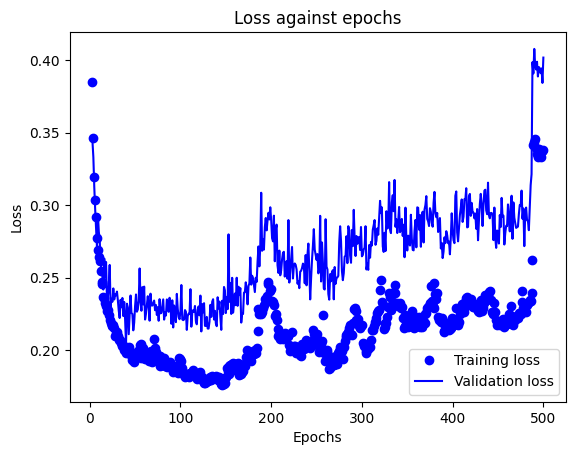

In [35]:
# Plot training and validation accuracy for each epoch

cut = 2 # This removes first epoch (usually very incorrect) to help the graph scale correctly
epochs = range(cut+1, num_epochs + 1)
plt.plot(epochs, avg_train_accuracy[cut:], "bo", label="Training loss")
plt.plot(epochs, avg_val_accuracy[cut:], "b", label="Validation loss")
# plt.axvline(15, label="Epoch 14")
plt.title("Loss against epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("good fitting info.png")
plt.show()